
# Download the Unsplash dataset (photos) and Create the RAMP Dataset

This notebook is used to download all images from the Unsplash dataset: https://github.com/unsplash/datasets. version Lite (25000 images) 


In [1]:
from pathlib import Path

unsplash_dataset_path = Path("unsplash-research-dataset-lite-latest")

## Load the dataset

The `photos.tsv000` contains metadata about the photos in the dataset, but not the photos themselves. We will use the URLs of the photos to download the actual images.

In [2]:
import pandas as pd

# Read the photos table
photos = pd.read_csv(unsplash_dataset_path / "photos.tsv000", sep='\t', header=0)

# Extract the IDs and the URLs of the photos
photo_urls = photos[['photo_id', 'photo_image_url']].values.tolist()

# Print some statistics
print(f'Photos in the dataset: {len(photo_urls)}')

Photos in the dataset: 25000


The file name of each photo corresponds to its unique ID from Unsplash. We will download the photos in a reduced resolution (640 pixels width), because they are downscaled by CLIP anyway.

CREATE THE "photos" DIRECTORY BEFORE LAUNCHING (must be created in the depository 'unsplash-research-dataset-lite-latest')

In [3]:
import urllib.request

# Path where the photos will be downloaded

photos_donwload_path = unsplash_dataset_path / "photos"

# Function that downloads a single photo
def download_photo(photo):
    # Get the ID of the photo
    photo_id = photo[0]

    # Get the URL of the photo (setting the width to 640 pixels)
    photo_url = photo[1] + "?w=640"

    # Path where the photo will be stored
    photo_path = photos_donwload_path / (photo_id + ".jpg")

    # Only download a photo if it doesn't exist
    if not photo_path.exists():
        try:
            urllib.request.urlretrieve(photo_url, photo_path)
        except:
            # Catch the exception if the download fails for some reason
            print(f"Cannot download {photo_url}")
            pass

Now the actual download! The download can be parallelized very well, so we will use a thread pool. You may need to tune the `threads_count` parameter to achieve the optimzal performance based on your Internet connection. For me even 128 worked quite well.

Uncomment to launch

In [4]:
from multiprocessing.pool import ThreadPool

# # Create the thread pool
# threads_count = 16
# pool = ThreadPool(threads_count)

# # Start the download
# pool.map(download_photo, photo_urls)

# # Display some statistics
# display(f'Photos downloaded: {len(photos)}')

Actually, we have 24978 photos

# Image transformation
Let's analyze one image and how we will compress it

(800, 640, 3)


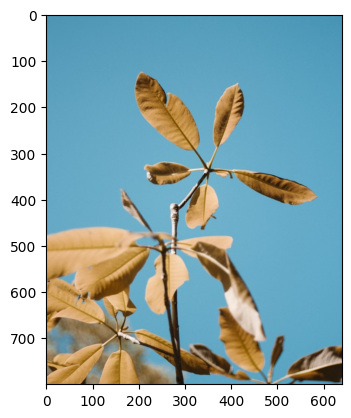

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(photos_donwload_path / '__1Mu7EZXOM.jpg')
imgplot = plt.imshow(img)
print(img.shape)

In [6]:
def resize_image(img, size_factor=5, verbose=False):
    """
    Resize original image to ensure its shape is a multiple of size_factor in each spatial dimension
    """
    H_in = img.shape[0] # Height
    W_in = img.shape[1] # Width
    H_out = H_in - (H_in % size_factor)
    W_out = W_in - (W_in % size_factor)
    img_resized = img[:H_out, :W_out, :]
    if verbose:
        print("old format: ", H_in, W_in)
        print("reshaped: ", H_out, W_out)
    return img_resized

In [7]:
def transform_image(img, size_factor=5):
    """
    Reduce resolution of image by a size factor and convert to black and white
    Returns an image of lower size than the original one
    
    Parameters
    ----------
    size_factor: factor resolution change (size_factor = 2, resolution will be divided by 2 in each spatial dimension)
    Returns
    -------
    A black & white image of the spatial dimension of the input image divided by size_factor (no channel)
    """
    from skimage.measure import block_reduce
    import numpy as np
    img_down = block_reduce(img, block_size=(size_factor, size_factor, 1), func=np.mean).astype(int) # reduce resolution
    img_out = np.mean(img_down, axis=2) # convert to Black & White
    
    return img_out

(160, 128)


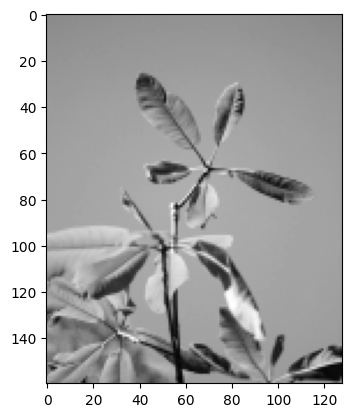

In [8]:
size_factor = 5
img_resized = resize_image(img, size_factor=size_factor)
img_down = transform_image(img_resized, size_factor=size_factor)
print(img_down.shape)
plt.imshow(img_down, cmap='gray')

Here is a way to come back to the initial image format (full resolution and RGB format, actually we only duplicate onto 3 channels)

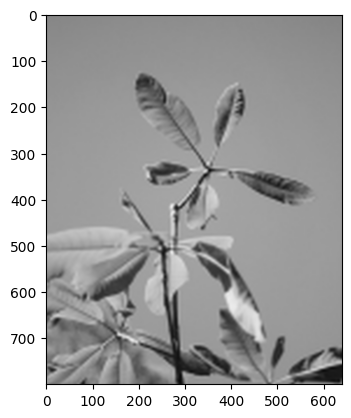

In [9]:
import scipy.ndimage
import numpy as np
img_prep = np.expand_dims(img_down, 2) # add a 3rd dimension for channel
img_prep = np.repeat(img_prep, 3, axis=2) # repeat the same data for each RGB channel
img_prep[:, :, 0] = np.clip(img_prep[:, :, 0] - 0, 0, 255) # add or remove color artificially for the full picture
img_prep[:, :, 1] = np.clip(img_prep[:, :, 0] + 0, 0, 255) # add or remove color artificially
img_prep[:, :, 2] = np.clip(img_prep[:, :, 0] + 0, 0, 255) # add or remove color artificially
img_reconstructed = scipy.ndimage.zoom(img_prep, (size_factor, size_factor, 1), order=3).astype(int)
# print(img_reconstructed.shape)
plt.imshow(img_reconstructed)

In [10]:
img_random = np.random.randint(0, 255, size=img_resized.shape)
rmse_resized = np.sqrt(np.sum((img_resized/255 - img_resized/255)**2) / img_resized.size)
rmse_reconstructed = np.sqrt(np.sum((img_reconstructed/255 - img_resized/255)**2) / img_resized.size)
rmse_random = np.sqrt(np.sum((img_random/255 - img_resized/255)**2) / img_resized.size)
print("rmse original (sanity check): ", rmse_resized)
print("rmse reconstructed image: ", rmse_reconstructed)
print("rmse random image: ", rmse_random)

rmse original (sanity check):  0.0
rmse reconstructed image:  0.15858597161993837
rmse random image:  0.3566010545883933


# Dataset creation

Create the "Dataset" depository before launching (in the same depository as this notebook)

In [11]:
import glob
from PIL import Image
from pathlib import Path
from tqdm import tqdm

photos_path = Path("unsplash-research-dataset-lite-latest") / "photos"
save_path_str = "Dataset/"
counter = 0
size_factor = 5
pathlist = Path(photos_path).glob('**/*.jpg')
for path in tqdm(pathlist):
    # print(path)
    img_in = resize_image(mpimg.imread(path), size_factor = size_factor) # Resize original image
    img_out = transform_image(img_in, size_factor = size_factor) # generate low resolution b&w image
    img_in_filename = save_path_str + str(format(counter, '05d')) + "_hi.jpg"
    img_out_filename = save_path_str + str(format(counter, '05d')) + "_lo.jpg"
    mpimg.imsave(img_in_filename, img_in)
    mpimg.imsave(img_out_filename, img_out, cmap='gray')
    # plt.imshow(img)
    counter += 1
    if counter >=25000:
        break

0it [00:00, ?it/s]

24977it [16:44, 24.87it/s]
